In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator # Using AerSimulator for simulation
import numpy as np
from qiskit.visualization import plot_histogram

In [2]:
# --- 1. Define the AND Oracle ---
# Computes |x1> |x0> |y> -> |x1> |x0> |y XOR (x1 AND x0)>
# The result (x1 AND x0) is 1 iff both x1 and x0 are 1.
# This is exactly what a Toffoli (CCX) gate does.
def create_and_oracle(n_inputs=2, name='AND Oracle'):
    """Creates a QuantumCircuit implementing the AND oracle."""
    if n_inputs != 2:
        raise ValueError("This specific AND oracle implementation requires exactly 2 input qubits.")

    # Define registers
    input_qr = QuantumRegister(n_inputs, name='input')
    ancilla_qr = QuantumRegister(1, name='ancilla')
    qc = QuantumCircuit(input_qr, ancilla_qr, name=name)

    # Apply CCX gate: Flips ancilla (target) if both inputs (controls) are |1>
    # Controls: input_qr[0], input_qr[1]
    # Target: ancilla_qr[0]
    qc.ccx(input_qr[0], input_qr[1], ancilla_qr[0])

    return qc


In [3]:
# --- 2. Define the OR Oracle ---
# Computes |x1> |x0> |y> -> |x1> |x0> |y XOR (x1 OR x0)>
# The result (x1 OR x0) is 1 if x1 is 1, or x0 is 1, or both are 1.
# It's 0 only if both x1 and x0 are 0.
# We can use De Morgan's law: (x1 OR x0) = NOT ((NOT x1) AND (NOT x0))
# So, we flip the inputs, apply CCX, then flip the inputs back.
# Finally, we flip the ancilla to get the OR result instead of NAND.
# Alternatively, a simpler construction exists:
# CX(in[0], ancilla), CX(in[1], ancilla), CCX(in[0], in[1], ancilla)
# Let's verify this simpler construction:
# State |x1>|x0>|0>
# After CX(0, 2): |x1>|x0>|x0>
# After CX(1, 2): |x1>|x0>|x0 XOR x1>
# After CCX(0, 1, 2): |x1>|x0>|(x0 XOR x1) XOR (x0 AND x1)>
# Truth Table Check:
# x1=0, x0=0: (0 XOR 0) XOR (0 AND 0) = 0 XOR 0 = 0. Correct (OR is 0)
# x1=0, x0=1: (1 XOR 0) XOR (1 AND 0) = 1 XOR 0 = 1. Correct (OR is 1)
# x1=1, x0=0: (0 XOR 1) XOR (0 AND 1) = 1 XOR 0 = 1. Correct (OR is 1)
# x1=1, x0=1: (1 XOR 1) XOR (1 AND 1) = 0 XOR 1 = 1. Correct (OR is 1)
# This construction works!
def create_or_oracle(n_inputs=2, name='OR Oracle'):
    """Creates a QuantumCircuit implementing the OR oracle."""
    if n_inputs != 2:
        raise ValueError("This specific OR oracle implementation requires exactly 2 input qubits.")

    # Define registers
    input_qr = QuantumRegister(n_inputs, name='input')
    ancilla_qr = QuantumRegister(1, name='ancilla')
    qc = QuantumCircuit(input_qr, ancilla_qr, name=name)

    # Apply the sequence: CX, CX, CCX
    qc.cx(input_qr[0], ancilla_qr[0])
    qc.cx(input_qr[1], ancilla_qr[0])
    qc.ccx(input_qr[0], input_qr[1], ancilla_qr[0]) # This corrects the case where both are 1

    return qc

In [4]:
# --- 3. Test the Oracles ---

n_inputs = 2
# We need registers for the full test circuit
input_qr = QuantumRegister(n_inputs, name='qin')
ancilla_qr = QuantumRegister(1, name='anc')
# We measure the ancilla bit to check the function result
output_cr = ClassicalRegister(1, name='cout')

# Get the oracle circuits
and_oracle_circuit = create_and_oracle(n_inputs)
or_oracle_circuit = create_or_oracle(n_inputs)

# Use AerSimulator
simulator = AerSimulator()

In [5]:
print("--- Testing AND Oracle ---")
# Test for all 4 input basis states: |00>, |01>, |10>, |11>
for i in range(2**n_inputs):
    # Create the full test circuit for this input
    test_qc = QuantumCircuit(input_qr, ancilla_qr, output_cr, name=f'AND_Test_{i}')

    # Prepare the input state |x1 x0> |0>
    # i=0 -> |00>, i=1 -> |01>, i=2 -> |10>, i=3 -> |11>
    input_str = format(i, f'0{n_inputs}b') # e.g., '00', '01', '10', '11'
    print(f"Input: |{input_str}>|0>")

    # Apply X gates to input qubits based on input_str
    # Qiskit orders qubits qN-1...q0. input_str[0] is x1 (q1), input_str[1] is x0 (q0)
    if input_str[0] == '1': # Set q1 (input_qr[1])
        test_qc.x(input_qr[1])
    if input_str[1] == '1': # Set q0 (input_qr[0])
        test_qc.x(input_qr[0])

    test_qc.barrier()

    # Append the AND oracle
    # Note: Need to specify the exact qubits the oracle applies to
    qubit_map = [*input_qr, ancilla_qr[0]] # Map oracle qubits [in0, in1, anc] to circuit qubits
    test_qc.append(and_oracle_circuit.to_instruction(), qubit_map)

    test_qc.barrier()

    # Measure the ancilla qubit into the classical bit
    test_qc.measure(ancilla_qr[0], output_cr[0])

    # Simulate
    compiled_circuit = transpile(test_qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(compiled_circuit)

    # Calculate expected result (classical AND)
    x1 = int(input_str[0])
    x0 = int(input_str[1])
    expected_result = x1 & x0 # Bitwise AND
    print(f"  Expected Ancilla Output: |{expected_result}>")
    print(f"  Simulation Result (Ancilla Measurement): {counts}")
    # Optional: Draw the first circuit
    # if i == 0:
    #     print("\nCircuit Diagram (Input |00>):")
    #     print(test_qc.draw(output='text'))



--- Testing AND Oracle ---
Input: |00>|0>
  Expected Ancilla Output: |0>
  Simulation Result (Ancilla Measurement): {'0': 1024}
Input: |01>|0>
  Expected Ancilla Output: |0>
  Simulation Result (Ancilla Measurement): {'0': 1024}
Input: |10>|0>
  Expected Ancilla Output: |0>
  Simulation Result (Ancilla Measurement): {'0': 1024}
Input: |11>|0>
  Expected Ancilla Output: |1>
  Simulation Result (Ancilla Measurement): {'1': 1024}



--- Testing OR Oracle ---
Input: |00>|0>
  Expected Ancilla Output: |0>
  Simulation Result (Ancilla Measurement): {'0': 1024}
Input: |01>|0>
  Expected Ancilla Output: |1>
  Simulation Result (Ancilla Measurement): {'1': 1024}
Input: |10>|0>
  Expected Ancilla Output: |1>
  Simulation Result (Ancilla Measurement): {'1': 1024}
Input: |11>|0>
  Expected Ancilla Output: |1>
  Simulation Result (Ancilla Measurement): {'1': 1024}

--- AND Oracle Circuit ---


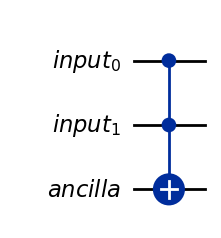


--- OR Oracle Circuit ---


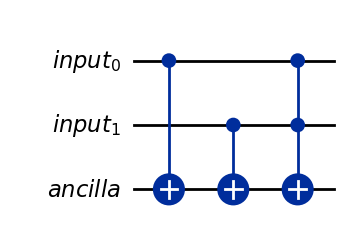

In [6]:
print("\n--- Testing OR Oracle ---")
# Test for all 4 input basis states: |00>, |01>, |10>, |11>
for i in range(2**n_inputs):
    # Create the full test circuit for this input
    test_qc = QuantumCircuit(input_qr, ancilla_qr, output_cr, name=f'OR_Test_{i}')

    # Prepare the input state |x1 x0> |0>
    input_str = format(i, f'0{n_inputs}b')
    print(f"Input: |{input_str}>|0>")
    if input_str[0] == '1': # Set q1 (input_qr[1])
        test_qc.x(input_qr[1])
    if input_str[1] == '1': # Set q0 (input_qr[0])
        test_qc.x(input_qr[0])
    test_qc.barrier()

    # Append the OR oracle
    qubit_map = [*input_qr, ancilla_qr[0]]
    test_qc.append(or_oracle_circuit.to_instruction(), qubit_map)

    test_qc.barrier()

    # Measure the ancilla qubit
    test_qc.measure(ancilla_qr[0], output_cr[0])

    # Simulate
    compiled_circuit = transpile(test_qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(compiled_circuit)

    # Calculate expected result (classical OR)
    x1 = int(input_str[0])
    x0 = int(input_str[1])
    expected_result = x1 | x0 # Bitwise OR
    print(f"  Expected Ancilla Output: |{expected_result}>")
    print(f"  Simulation Result (Ancilla Measurement): {counts}")
    # Optional: Draw the first circuit
    # if i == 0:
    #     print("\nCircuit Diagram (Input |00>):")
    #     print(test_qc.draw(output='text'))

# Optional: Display the oracle circuits themselves
print("\n--- AND Oracle Circuit ---")
display(and_oracle_circuit.draw(output='mpl'))

print("\n--- OR Oracle Circuit ---")
display(or_oracle_circuit.draw(output='mpl'))